In [1259]:
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

engine = create_engine("sqlite:////Users/nk/Documents/Metis/07 Engineering/Project/data/weather.db")

In [1260]:
conn = engine.connect()

In [1261]:
database_tables = engine.table_names()
database_tables

['JFK',
 'KACK',
 'KACY',
 'KBLM',
 'KBRO',
 'KDLS',
 'KDVO',
 'KEYW',
 'KFRG',
 'KHSE',
 'KHTO',
 'KJFK',
 'KMIA',
 'KMKG',
 'KNYC',
 'KOAK',
 'KPIL',
 'KSAN',
 'PHKO']

In [1262]:
# s = text("SELECT REPLACE(DATE, 'T', ' '), HourlyDewPointTemperature \
#             FROM KACK \
#             WHERE REPORT_TYPE1 = 'FM-15'")
# result = conn.execute(s)

In [1263]:
# result.fetchone()

In [1264]:
database_tables[18]

'PHKO'

In [1265]:
user_request_station = database_tables[18]

df = pd.read_sql("SELECT DATE, HourlyDryBulbTemperature, HourlyWindDirection, HourlyWindSpeed \
                  FROM %s WHERE REPORT_TYPE1 = 'FM-15';" % (user_request_station), engine)

In [1266]:
len(df)

91997

In [1267]:
df["HourlyDryBulbTemperature"] = pd.to_numeric(df.iloc[:,1], errors='coerce')
df["HourlyWindDirection"] = pd.to_numeric(df.iloc[:,2], errors='coerce')
df["HourlyWindSpeed"] = pd.to_numeric(df.iloc[:,3], errors='coerce')

In [1268]:
df.index = pd.to_datetime(df.DATE, format = "%Y-%m-%dT%H:%M:%S")
# .dt.round('H').dt.hour

In [1269]:
df2 = df.dropna(axis=0, subset = ['HourlyDryBulbTemperature','HourlyWindDirection','HourlyWindSpeed'])

In [1270]:
df2["HourlyKnots"] = df2.HourlyWindSpeed.apply(lambda x: x/1.852)   

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/119565490.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["HourlyKnots"] = df2.HourlyWindSpeed.apply(lambda x: x/1.852)


In [1271]:
def knots_min (x):
    if x >= 9:
        return 1
    else:
        return 0
    
def knots_op (x):
    if x >= 12:
        return 1
    else:
        return 0

In [1272]:
df2["windcond_min"] = df2.HourlyKnots.apply(knots_min)
df2["min_count_start"] = np.where(df2["windcond_min"] + df2["windcond_min"].shift(1)<=1, 0, df2["windcond_min"])
df2["min_count_accum"] = df2.groupby((df2.min_count_start==0).cumsum()).cumcount()

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/3768605115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["windcond_min"] = df2.HourlyKnots.apply(knots_min)
/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/3768605115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["min_count_start"] = np.where(df2["windcond_min"] + df2["windcond_min"].shift(1)<=1, 0, df2["windcond_min"])
/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/3768605115.py:3: Settin

In [1273]:
df2["windcond_op"] = df2.HourlyKnots.apply(knots_op)
df2["op_count_start"] = np.where(df2["windcond_op"] + df2["windcond_op"].shift(1)<=1, 0, df2["windcond_op"])
df2["op_count_accum"] = df2.groupby((df2.op_count_start==0).cumsum()).cumcount()

/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/306068253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["windcond_op"] = df2.HourlyKnots.apply(knots_op)
/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/306068253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["op_count_start"] = np.where(df2["windcond_op"] + df2["windcond_op"].shift(1)<=1, 0, df2["windcond_op"])
/var/folders/5s/wl47dskn0072dxn6tsvvg4mh0000gn/T/ipykernel_72220/306068253.py:3: SettingWithCopy

In [1274]:
mask = ((df2.index.hour >= 6) & (df2.index.hour <= 20))
df3 = df2[mask].copy()

In [1275]:
df3.groupby(df3.index.month)["HourlyWindSpeed"].mean()

DATE
1     8.363616
2     9.394559
3     9.042024
4     9.120993
5     9.140907
6     8.878939
7     9.040116
8     9.089907
9     8.928980
10    8.439500
11    8.184720
12    8.210319
Name: HourlyWindSpeed, dtype: float64

In [1276]:
df3.groupby(df3.index.month)["min_count_accum"].max()

DATE
1     15
2     16
3     28
4     15
5      7
6      3
7      8
8      6
9     10
10    20
11    11
12    13
Name: min_count_accum, dtype: int64

In [1277]:
import matplotlib.pyplot as plt

[Text(1, 0, 'Jan'),
 Text(2, 0, 'Feb'),
 Text(3, 0, 'Mar'),
 Text(4, 0, 'Apr'),
 Text(5, 0, 'May'),
 Text(6, 0, 'Jun'),
 Text(7, 0, 'Jul'),
 Text(8, 0, 'Aug'),
 Text(9, 0, 'Sep'),
 Text(10, 0, 'Oct'),
 Text(11, 0, 'Nov'),
 Text(12, 0, 'Dec')]

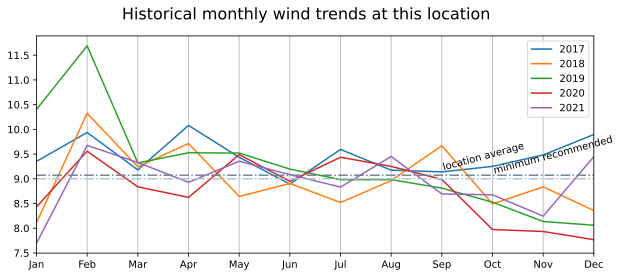

In [1281]:
df4 = df3[df3.index.year>=2017].copy()

fig, ax = plt.subplots(figsize=(10,4))
fig.suptitle("Historical monthly wind trends at this location", fontsize=16)
ax.plot(df4.groupby([df4.index.year, df4.index.month]).mean()["HourlyWindSpeed"].unstack(level=0))
ax.legend(df4.groupby([df4.index.year, df4.index.month]).mean()["HourlyWindSpeed"].unstack(level=0).columns)
ax.set_xticks(range(1,13))
ax.margins(x = 0)
ax.grid(visible=True, which='major', axis="x")
locavg = df4["HourlyWindSpeed"].mean()
ax.hlines(xmin = 1, xmax = 12, y = locavg, colors = "slategrey", linestyles='dashdot')
ax.text(10,9.1,'minimum recommended',rotation=15)
ax.hlines(xmin = 1, xmax = 12, y = 9, colors = "lightsteelblue", linestyles='dashdot')
ax.text(9,locavg+0.1,'location average',rotation=15)
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

In [1279]:
dfg = pd.DataFrame(df3.groupby(df3.index.month)["min_count_accum"].value_counts()).unstack(level=0)

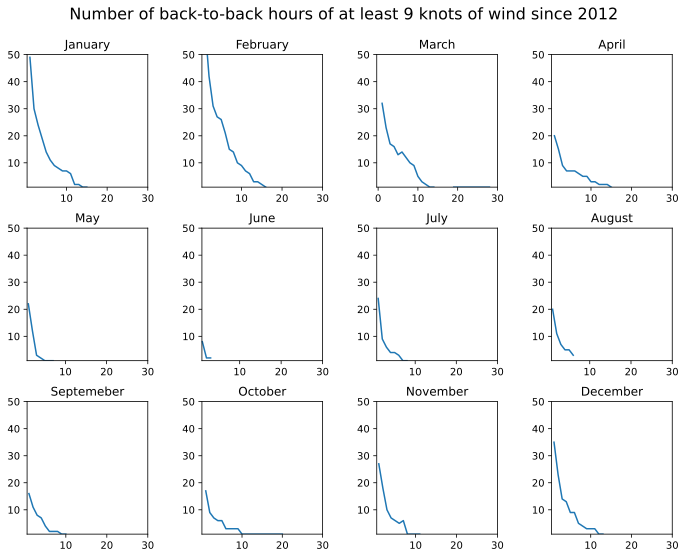

In [1280]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(nrows=3, ncols=4, figsize=(10,8))
fig.suptitle(f"Number of back-to-back hours of at least 9 knots of wind since {min(df3.index.year)}", fontsize=16)
fig.tight_layout(pad=2)
ax1.plot(dfg.index[1:], dfg.iloc[1:,0]);   ax1.set_xlim(xmax=30);  ax1.set_ylim(1,50);  ax1.set_title('January');
ax2.plot(dfg.index[1:], dfg.iloc[1:,1]);   ax2.set_xlim(xmax=30);  ax2.set_ylim(1,50);  ax2.set_title('February');
ax3.plot(dfg.index[1:], dfg.iloc[1:,2]);   ax3.set_xlim(xmax=30);  ax3.set_ylim(1,50);  ax3.set_title('March');
ax4.plot(dfg.index[1:], dfg.iloc[1:,3]);   ax4.set_xlim(xmax=30);  ax4.set_ylim(1,50);  ax4.set_title('April');
ax5.plot(dfg.index[1:], dfg.iloc[1:,4]);   ax5.set_xlim(xmax=30);  ax5.set_ylim(1,50);  ax5.set_title('May');
ax6.plot(dfg.index[1:], dfg.iloc[1:,5]);   ax6.set_xlim(xmax=30);  ax6.set_ylim(1,50);  ax6.set_title('June');
ax7.plot(dfg.index[1:], dfg.iloc[1:,6]);   ax7.set_xlim(xmax=30);  ax7.set_ylim(1,50);  ax7.set_title('July');
ax8.plot(dfg.index[1:], dfg.iloc[1:,7]);   ax8.set_xlim(xmax=30);  ax8.set_ylim(1,50);  ax8.set_title('August');
ax9.plot(dfg.index[1:], dfg.iloc[1:,8]);   ax9.set_xlim(xmax=30);  ax9.set_ylim(1,50);  ax9.set_title('Septemeber');
ax10.plot(dfg.index[1:], dfg.iloc[1:,9]);  ax10.set_xlim(xmax=30); ax10.set_ylim(1,50); ax10.set_title('October');
ax11.plot(dfg.index[1:], dfg.iloc[1:,10]); ax11.set_xlim(xmax=30); ax11.set_ylim(1,50); ax11.set_title('November');
ax12.plot(dfg.index[1:], dfg.iloc[1:,11]); ax12.set_xlim(xmax=30); ax12.set_ylim(1,50); ax12.set_title('December');
